In [63]:
import facebook
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
plt.style.use('ggplot')

# Jak jsem si ucast v tipovaci soutezi ulehcil (ale stejne nevyhral :( )
Na facebooku byla soutez u jednoho Brnenskeho burger baru "Kdo uhadne kolik vazi megaburger, ma ho zadarmo"  
Pritelkyne navrhla scraping ("umis vzit vsechny komentare a podivat se ktere cisla uz nekdo hadal?"), tak jsem se do toho pustil.  
Dostupne informace:

- fotka (viz nize) 
- burger vazi aspon 1500g (na instagramu se objevila fotka s podobnym kouskem, ze mel kilo a pul
- Oficialni sdeleni, ze nekteri lidi byli hoodne blizko, ale nikdo to netrefil presne. V tento okamzik jsem do souteze nastoupil ja a zbyvalo 12 h

<h1 id="tocheading">Obsah</h1>
<div id="toc"></div>


In [95]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')


<IPython.core.display.Javascript object>

In [87]:
from IPython.display import Image
Image(url='https://fbcdn-sphotos-d-a.akamaihd.net/hphotos-ak-xfp1/v/t1.0-9/s720x720/11937436_10153731730577147_3428897361406359533_n.jpg?oh=b58677ec726b0be8a1acec5624390086&oe=56A47D53&__gda__=1453313706_71353993e92c3932e9d19432bf140e94')

## Ziskat data
### Facebook api stuff
api_token se da ziskat [zde](https://developers.facebook.com/tools/explorer/), pokud by si to chtel nekdo vyzkouset

In [3]:
my_user_token = 'CAACEdEose0cBAMc8icVJ0lZBvR6bURMZBHgyL2VmmZAf8ZC0al9hyUOysD7pPbLB8mN0dJMaOpxsZAzmcocFnArqnZBzsEewqxuBXiswRTOIRZA0LgLwXYEZBOs18O5LqAhiZBv9iRuxZChyx15Vkz2SC42FUNr9F8BZBpqLnZBMzKGuJCO4YT5WFQrkDLEbCcIHcLKoZAHa0QqZAXzUHLurfsPzhh'
escobar = '108593382146_10153731730577147/comments'
g = facebook.GraphAPI(access_token=my_user_token)

V dobe psani tam bylo lehce pod 2000 komentaru


In [4]:
comments = g.get_object(escobar, limit=2000)


### Zkouska dat
Vetsina zaznamu se vyskytuje ve formatu [cislo]G/g

In [5]:
len(comments['data'])

2000

In [7]:
for c in comments['data'][:10]:
    print c['message']


1,2 kg
1387 gramů.
1670g
1439g
555g :)
950g
800g
850 g
513g
1650g


Ulozit data pro pripadne pozdejsi pouziti, protoze jak jsem pozdeji zjistil, facebook_api_key vydrzi asi tak hodinku

In [9]:
with open("escobar_comments.json", 'wb') as f:
    f.write(json.dumps(comments))

In [12]:
messages = [c['message'] for c in comments['data']]

## Vybrat z komentaru hodnoty gramaze + vycistit data
zachyti vsechny cisla z komentu i ve formatu napr.:
- 1.246kg
- 1234 g
- 1 234g
- 1.123456g

urcite by se dalo vymyslet robustnejsi reseni, ale pro tyto ucely by to mohlo stacit


In [13]:
def parse_comment(comment):
    return re.findall(r'\d+', comment, flags=re.IGNORECASE)

In [14]:
print "Celkem mame: {} zaznamu".format(len(messages))

Celkem mame: 2000 zaznamu


In [81]:
#maly test
print parse_comment('1 234g')
print parse_comment('1234g')
print parse_comment('1234')
print parse_comment('1.234 kg')
print parse_comment("1.23454631234")

['1', '234']
['1234']
['1234']
['1', '234']
['1', '23454631234']


In [16]:
#bude list of lists
vals = [parse_comment(x['message']) for x in comments['data']]

In [17]:
vals[:3]

[[u'1', u'2'], [u'1387'], [u'1670']]

tim ze vezmeme pouze prvni 4 cisla, tak zjistime hmotnost v gramech. Neni to presne, ale ve vetsine pripadu to bude fungovat (pokud ma cislo aspon 4 cisla). Urcite to nezachyti 1.2kg atp

In [20]:
# joined_vals = ["".join(n) for n in vals]
joined_vals4 = ["".join(n)[:4] for n in vals]

In [21]:
len(joined_vals4)

2000

In [22]:
joined_vals4.sort()
joined_vals4[:20]

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

In [23]:
joined_vals4 = [x for x in joined_vals4 if x != ""]
print len(joined_vals4)
joined_vals4[:20]



1972


[u'0730',
 u'1',
 u'1',
 u'1',
 u'1',
 u'1',
 u'1',
 u'1',
 u'1',
 u'1',
 u'1',
 u'1000',
 u'1000',
 u'1000',
 u'1000',
 u'1000',
 u'1000',
 u'1000',
 u'1000',
 u'1000']

In [24]:
joined_vals4 = [int(x) for x in joined_vals4 if not x.startswith('0')]
print len(joined_vals4)
joined_vals4[:20]

1971


[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000]

In [27]:
print "Nejmensi hodnota: {}".format(min(joined_vals4))
print "Nejvetsi hodnota: {}".format(max(joined_vals4))
print "Pocet zaznamu   : {}".format(len(joined_vals4))
print "Pocet unikatnich zaznamu: {}".format(len(set(joined_vals4)))

Nejmensi hodnota: 1
Nejvetsi hodnota: 9991
Pocet zaznamu   : 1971
Pocet unikatnich zaznamu: 861


In [28]:
def get_unique_numbers(a=1500,b=2000):
    vysledek = sorted(set(range(a,b)) - set(joined_vals4))
    print "Mezi {} a {} je {} dosud nehadanych cisel:\n".format(a,b,len(vysledek))
    for i in vysledek:
        print i

# Vysledky

In [84]:
#Nefunguje v nbviewer.ipython.org,
#ale jinak vyhodi interaktivni posuvniky ktere nam daji ktere cisla nebyly tipovany v danem rozmezi
interact(get_unique_numbers)

Mezi 1940 a 2000 je 43 dosud nehadanych cisel:

1940
1942
1943
1944
1946
1951
1952
1953
1954
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1981
1982
1988
1989
1991
1992
1994
1995
1996
1997
1998


None

# Pandas to the rescue!
Pouzito: [Pandas](http://pandas.pydata.org/)  
Cas na prozkoumani trendu a nejake obrazky

In [48]:
data = pd.DataFrame({"hodnota":joined_vals4})
data.sort('hodnota', ascending=False).head()

,hodnota
1970,9991
1882,9515
1802,9134
1790,9001
1770,8963


In [49]:
data.describe()

,hodnota
count,1971.000000
mean,1247.712329
std,767.130975
min,1.000000
25%,840.000000
50%,1172.000000
75%,1531.500000
max,9991.000000


## Cetnosti jednotlivych odpovedi

In [53]:
pocty = data.reset_index().groupby('hodnota').agg(len)
pocty.rename(columns={'index':'cetnost'},inplace=True)
pocty.sort('cetnost',ascending=False).head()


,cetnost
hodnota,
1500,40
1200,33
850,29
1250,28
750,26


## Prehled

In [69]:
print "Celkem bylo tipnuto {} unikatnich hodnot".format(len(pocty))
print "----------------------------------------"
print "{} ruznych hodnot bylo tipnuto prave 1x".format(len(pocty[pocty.cetnost == 1]))
print "{} ruznych hodnot bylo tipnuto prave 2x".format(len(pocty[pocty.cetnost == 2]))
print "{} ruznych hodnot bylo tipnuto prave 3x".format(len(pocty[pocty.cetnost == 3]))
print "---------------------------------------"
print "{} ruznych hodnot bylo tipnuto aspon 2x".format(len(pocty[pocty.cetnost > 1]))
print "{} ruznych hodnot bylo tipnuto aspon 5x".format(len(pocty[pocty.cetnost > 4]))

Celkem bylo tipnuto 861 unikatnich hodnot
----------------------------------------
498 ruznych hodnot bylo tipnuto prave 1x
184 ruznych hodnot bylo tipnuto prave 2x
68 ruznych hodnot bylo tipnuto prave 3x
---------------------------------------
363 ruznych hodnot bylo tipnuto aspon 2x
70 ruznych hodnot bylo tipnuto aspon 5x


In [66]:
pocty.describe()

,cetnost
count,861.000000
mean,2.289199
std,3.344379
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,40.000000


## Hodne oblibene odpovedi (vice nez 5x), serazeno

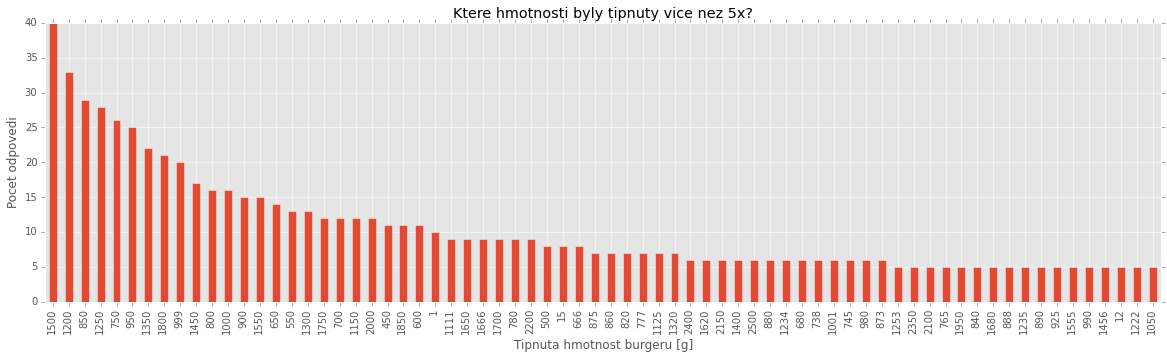

In [93]:
oblibene5 = pocty[pocty.cetnost >=5]
oblibene5_plot = oblibene5.sort('cetnost',ascending=False).plot(kind='bar',figsize=(20,5),legend=False)
oblibene5_plot.set_xlabel("Tipnuta hmotnost burgeru [g]")
oblibene5_plot.set_ylabel("Pocet odpovedi")
oblibene5_plot.set_title("Ktere hmotnosti byly tipnuty vice nez 5x?");

## Hodne oblibene odpovedi (vice nez 5x), neserazeno

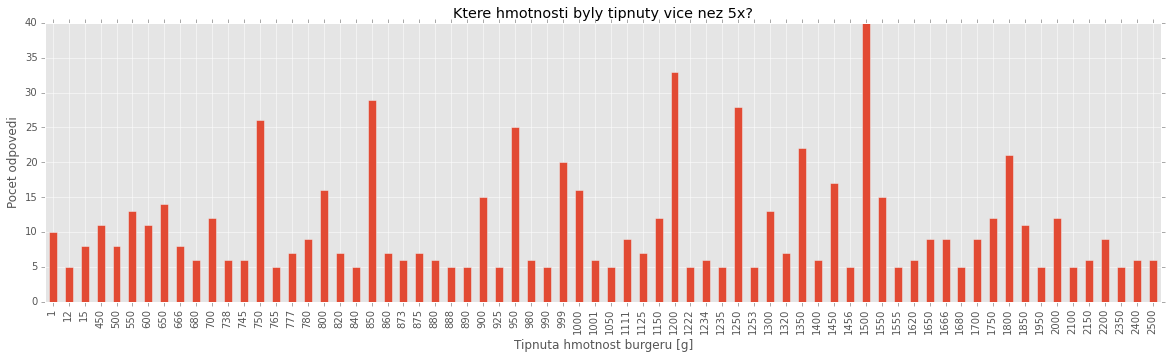

In [94]:
oblibene5_plot_sorted = oblibene5.plot(kind='bar',figsize=(20,5),legend=False)
oblibene5_plot_sorted.set_xlabel("Tipnuta hmotnost burgeru [g]")
oblibene5_plot_sorted.set_ylabel("Pocet odpovedi")
oblibene5_plot_sorted.set_title("Ktere hmotnosti byly tipnuty vice nez 5x?");

## Presnost dat
Tady se ukazuje, ze postup s takto jednoduchym regexem `r'\d+'` ma svoje mouchy.  
Hodnoty 1, a 15 puvodne byly pravdepodobne 1kg a 1.5kg, takze bych je mel bud  
a) vyradit  
b) vylepsit parsovaci funkci  

# Co (mi) z toho vyplyva?
- Lide tihnou k peknym kulatym cislum (750, 600, 800, 850, 900, 950, 1000, 1500,...) v situacich, kdy to nedava smysl. Leda bychom vedeli, ze kuchar byl puntickar a burger vazici 1512g je schopen obrat o platek salatu, aby vazil "peknych" 1500.
- = Pokud bude tipovaci soutez kde vyhrat muze jenom jeden, tak je velmi pravdepodobne ze pekne kulate cislo uz nekdo tipnul, takze radeji hadejte neco jineho
- **Organizatorum bych doporucil** ustanovit jednotny format odpovedi. Nevim jak to vyhodnocovali, ale verim ze kdyby zadali format xyzw g tak je to nejpresnejsi


# Jaky byl spravny vysledek? Aneb vyjimka potvrzuje pravidlo?
Spravna odpoved byla 1925 g, podle autoru nejblizsi odpoved byla 1926 g. Predpokladam, ze tip s hodnotou 1926 prisel drive nez 1924, a proto vyhral. Treba se tipsteri 1924 a 1926 ridili vyse uvedenym tvrzenim O:-) Docela tesne, ne? Ja sam jsem hadal 1694

In [90]:
data[(data.hodnota >= 1900) & (data.hodnota <=1950)]

,hodnota
1000,1900
1001,1900
1002,1900
1003,1900
1004,1903
1005,1905
1006,1913
1007,1919
1008,1919
1009,1920


# Jak jeste vice zpresnit odhad?
Zkousel jsem googlit "Average burger density", "bigmac density" atp, ze bych z fotky odhadnul jake ma tento burger rozmery a z toho vypocital hmotnost. Bohuzel (bohudik? mozna bych odhadoval jeste doted) jsem nenasel :(
